<a href="https://colab.research.google.com/github/maxshay/motley-crew-django-backend/blob/master/DocumentFormRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install poppler dependency for pdf2image
!apt-get install poppler-utils 
!apt install tesseract-ocr
!apt install libtesseract-dev

# install opencv and pdf2image
!pip3 install opencv-python pdf2image pytesseract

# import libraries
import os
import cv2
import numpy as np
import PIL
import pytesseract as pt

from pdf2image import convert_from_path
from PIL import Image
from numpy import *



Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use

In [2]:
pdfimages = convert_from_path('std200.pdf')
num_pages = len(pdfimages)

for i in range(num_pages):
   
      # Save pages as images in the pdf
    pdfimages[i].save('page'+ str(i) +'.jpg', 'JPEG')

  
# read image into array
image_array = cv2.imread('page4.jpg')

In [3]:
#Convert the image to grayscale
gray_scale = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

#Apply thresholding to image
_, img_bin = cv2.threshold(gray_scale, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin = 255 - img_bin

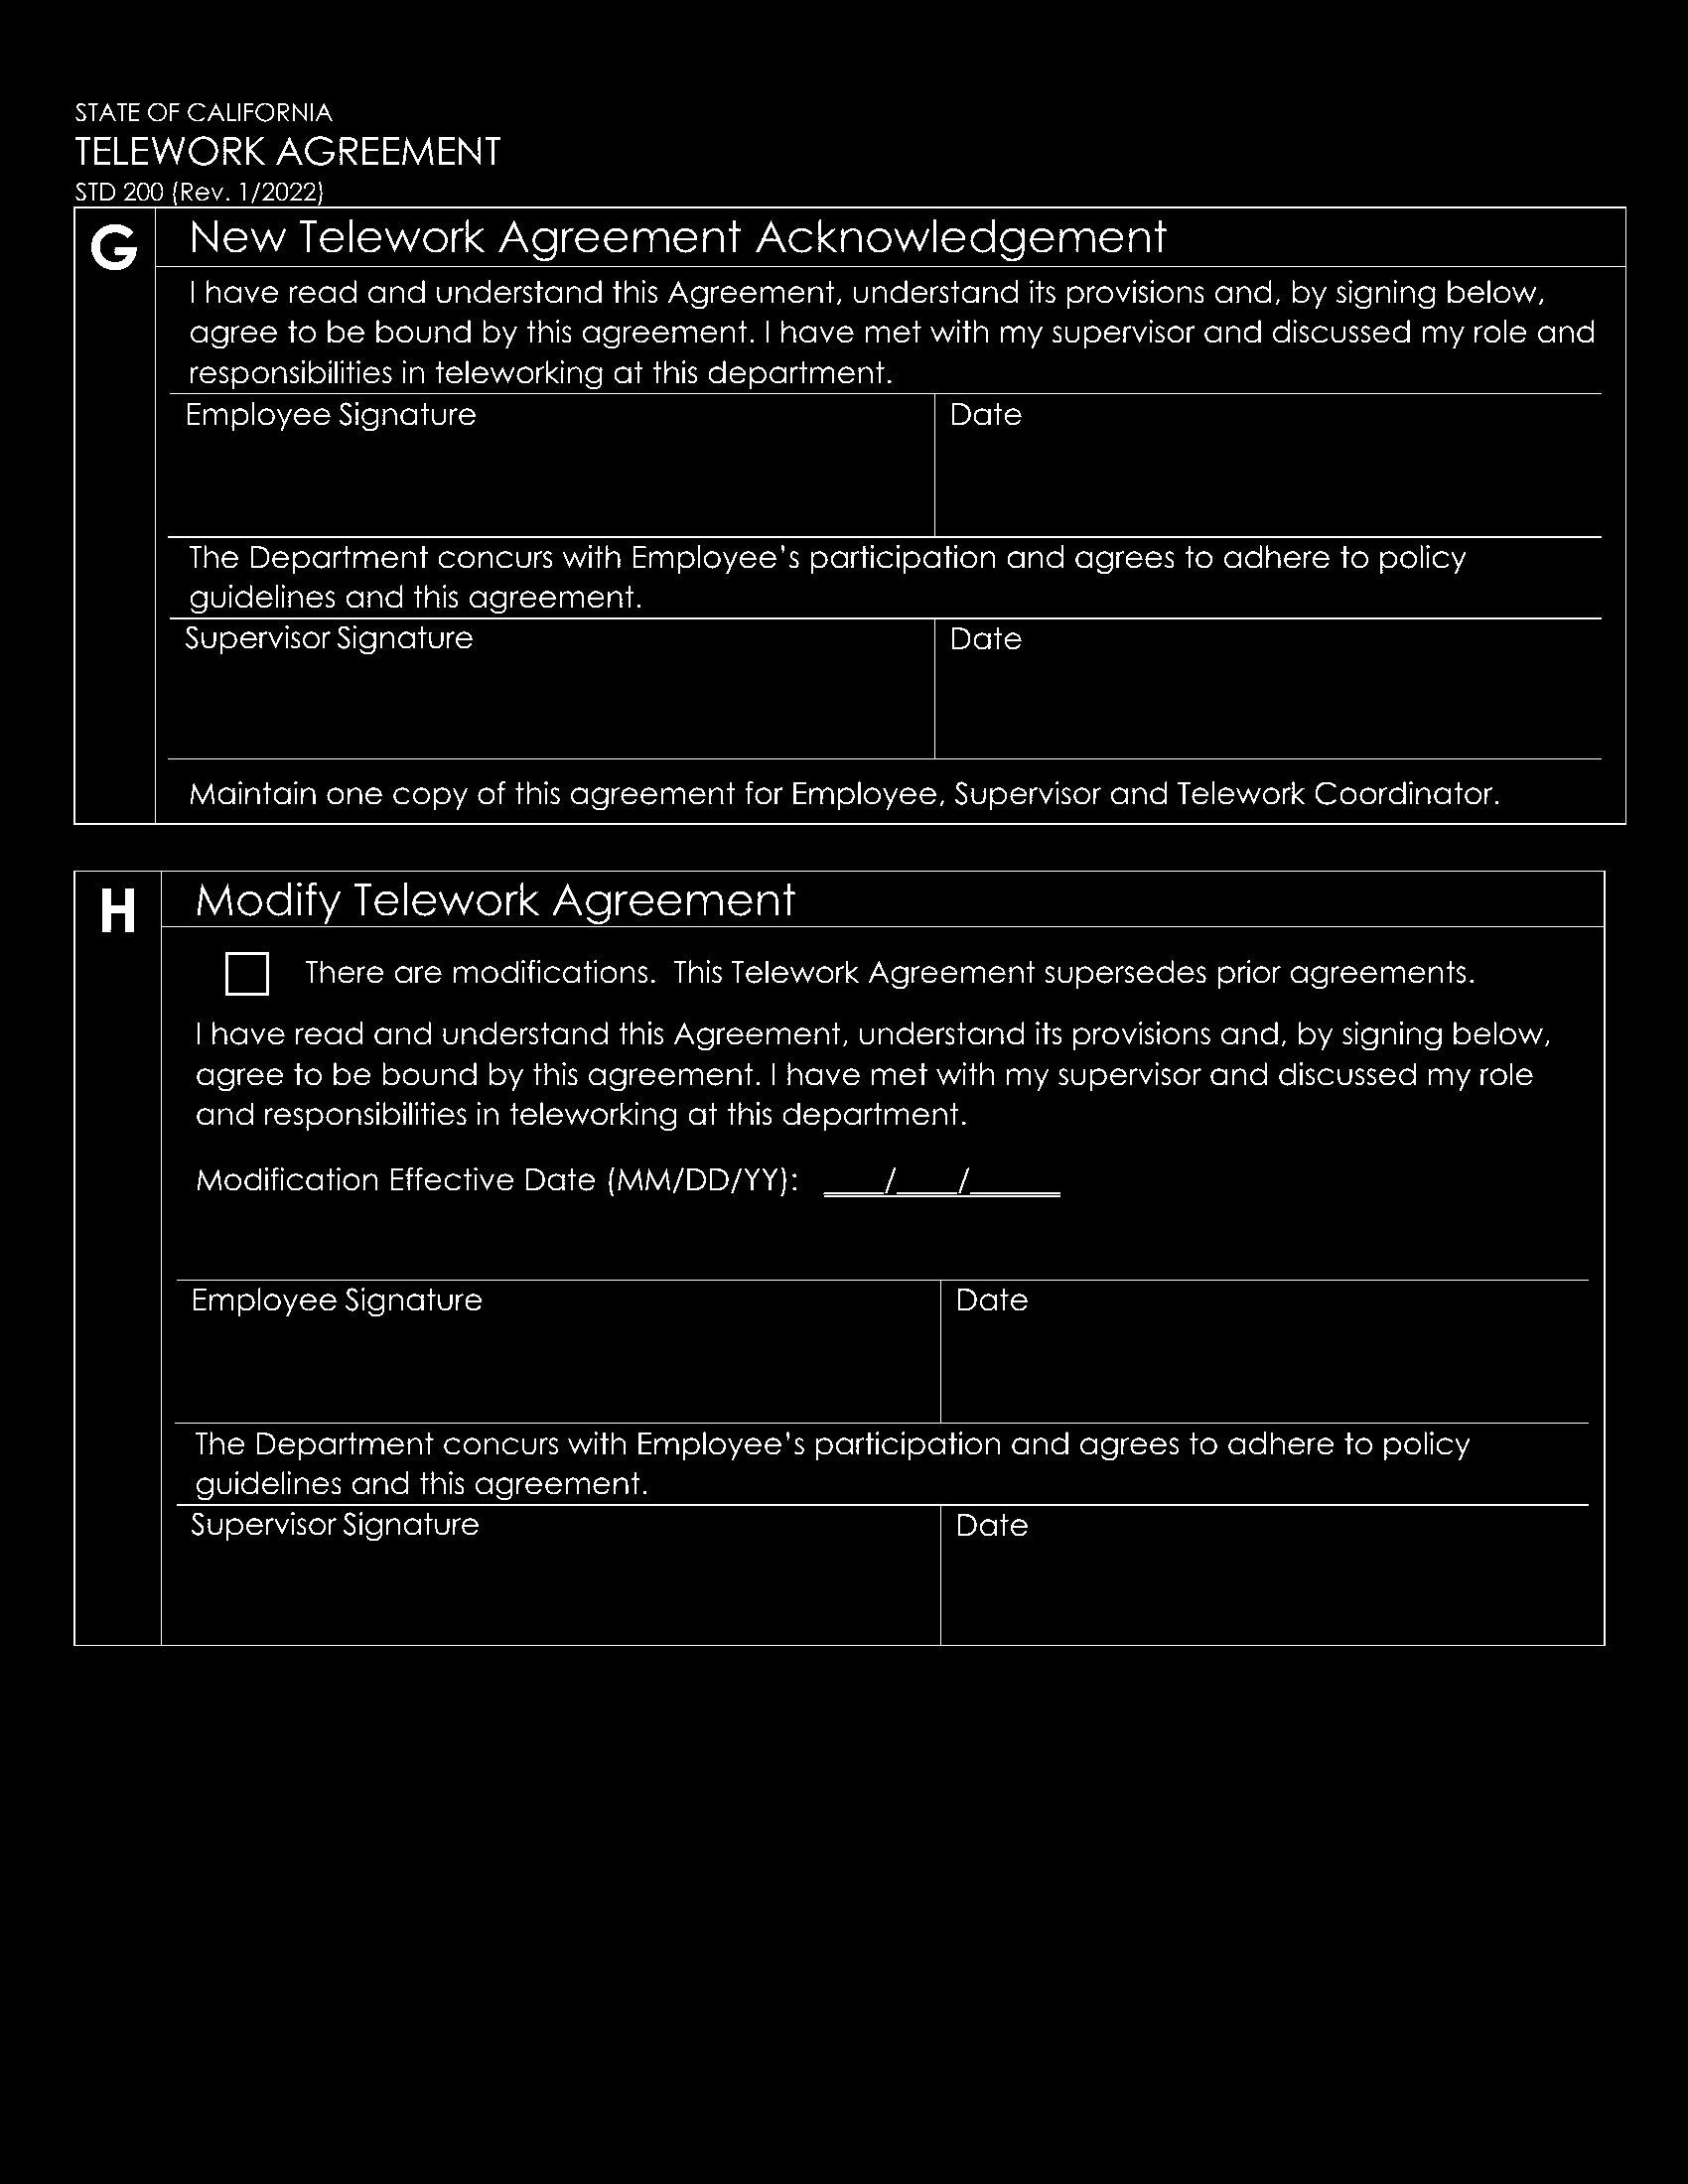

In [4]:
#Display grayscaled image
Image.fromarray(img_bin)

In [5]:
#Define a min width for line detection
line_min_width = 15

#Create the kernel to detect horizontal lines
kernal_h = np.ones((1,line_min_width), np.uint8)

#Create the kernel to detect vertical lines
kernal_v = np.ones((line_min_width,1), np.uint8)

#Apply horizontal kernel on the image
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)

#Apply verical kernel on the image
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)


#Combine the kernels
img_bin_final=img_bin_h|img_bin_v

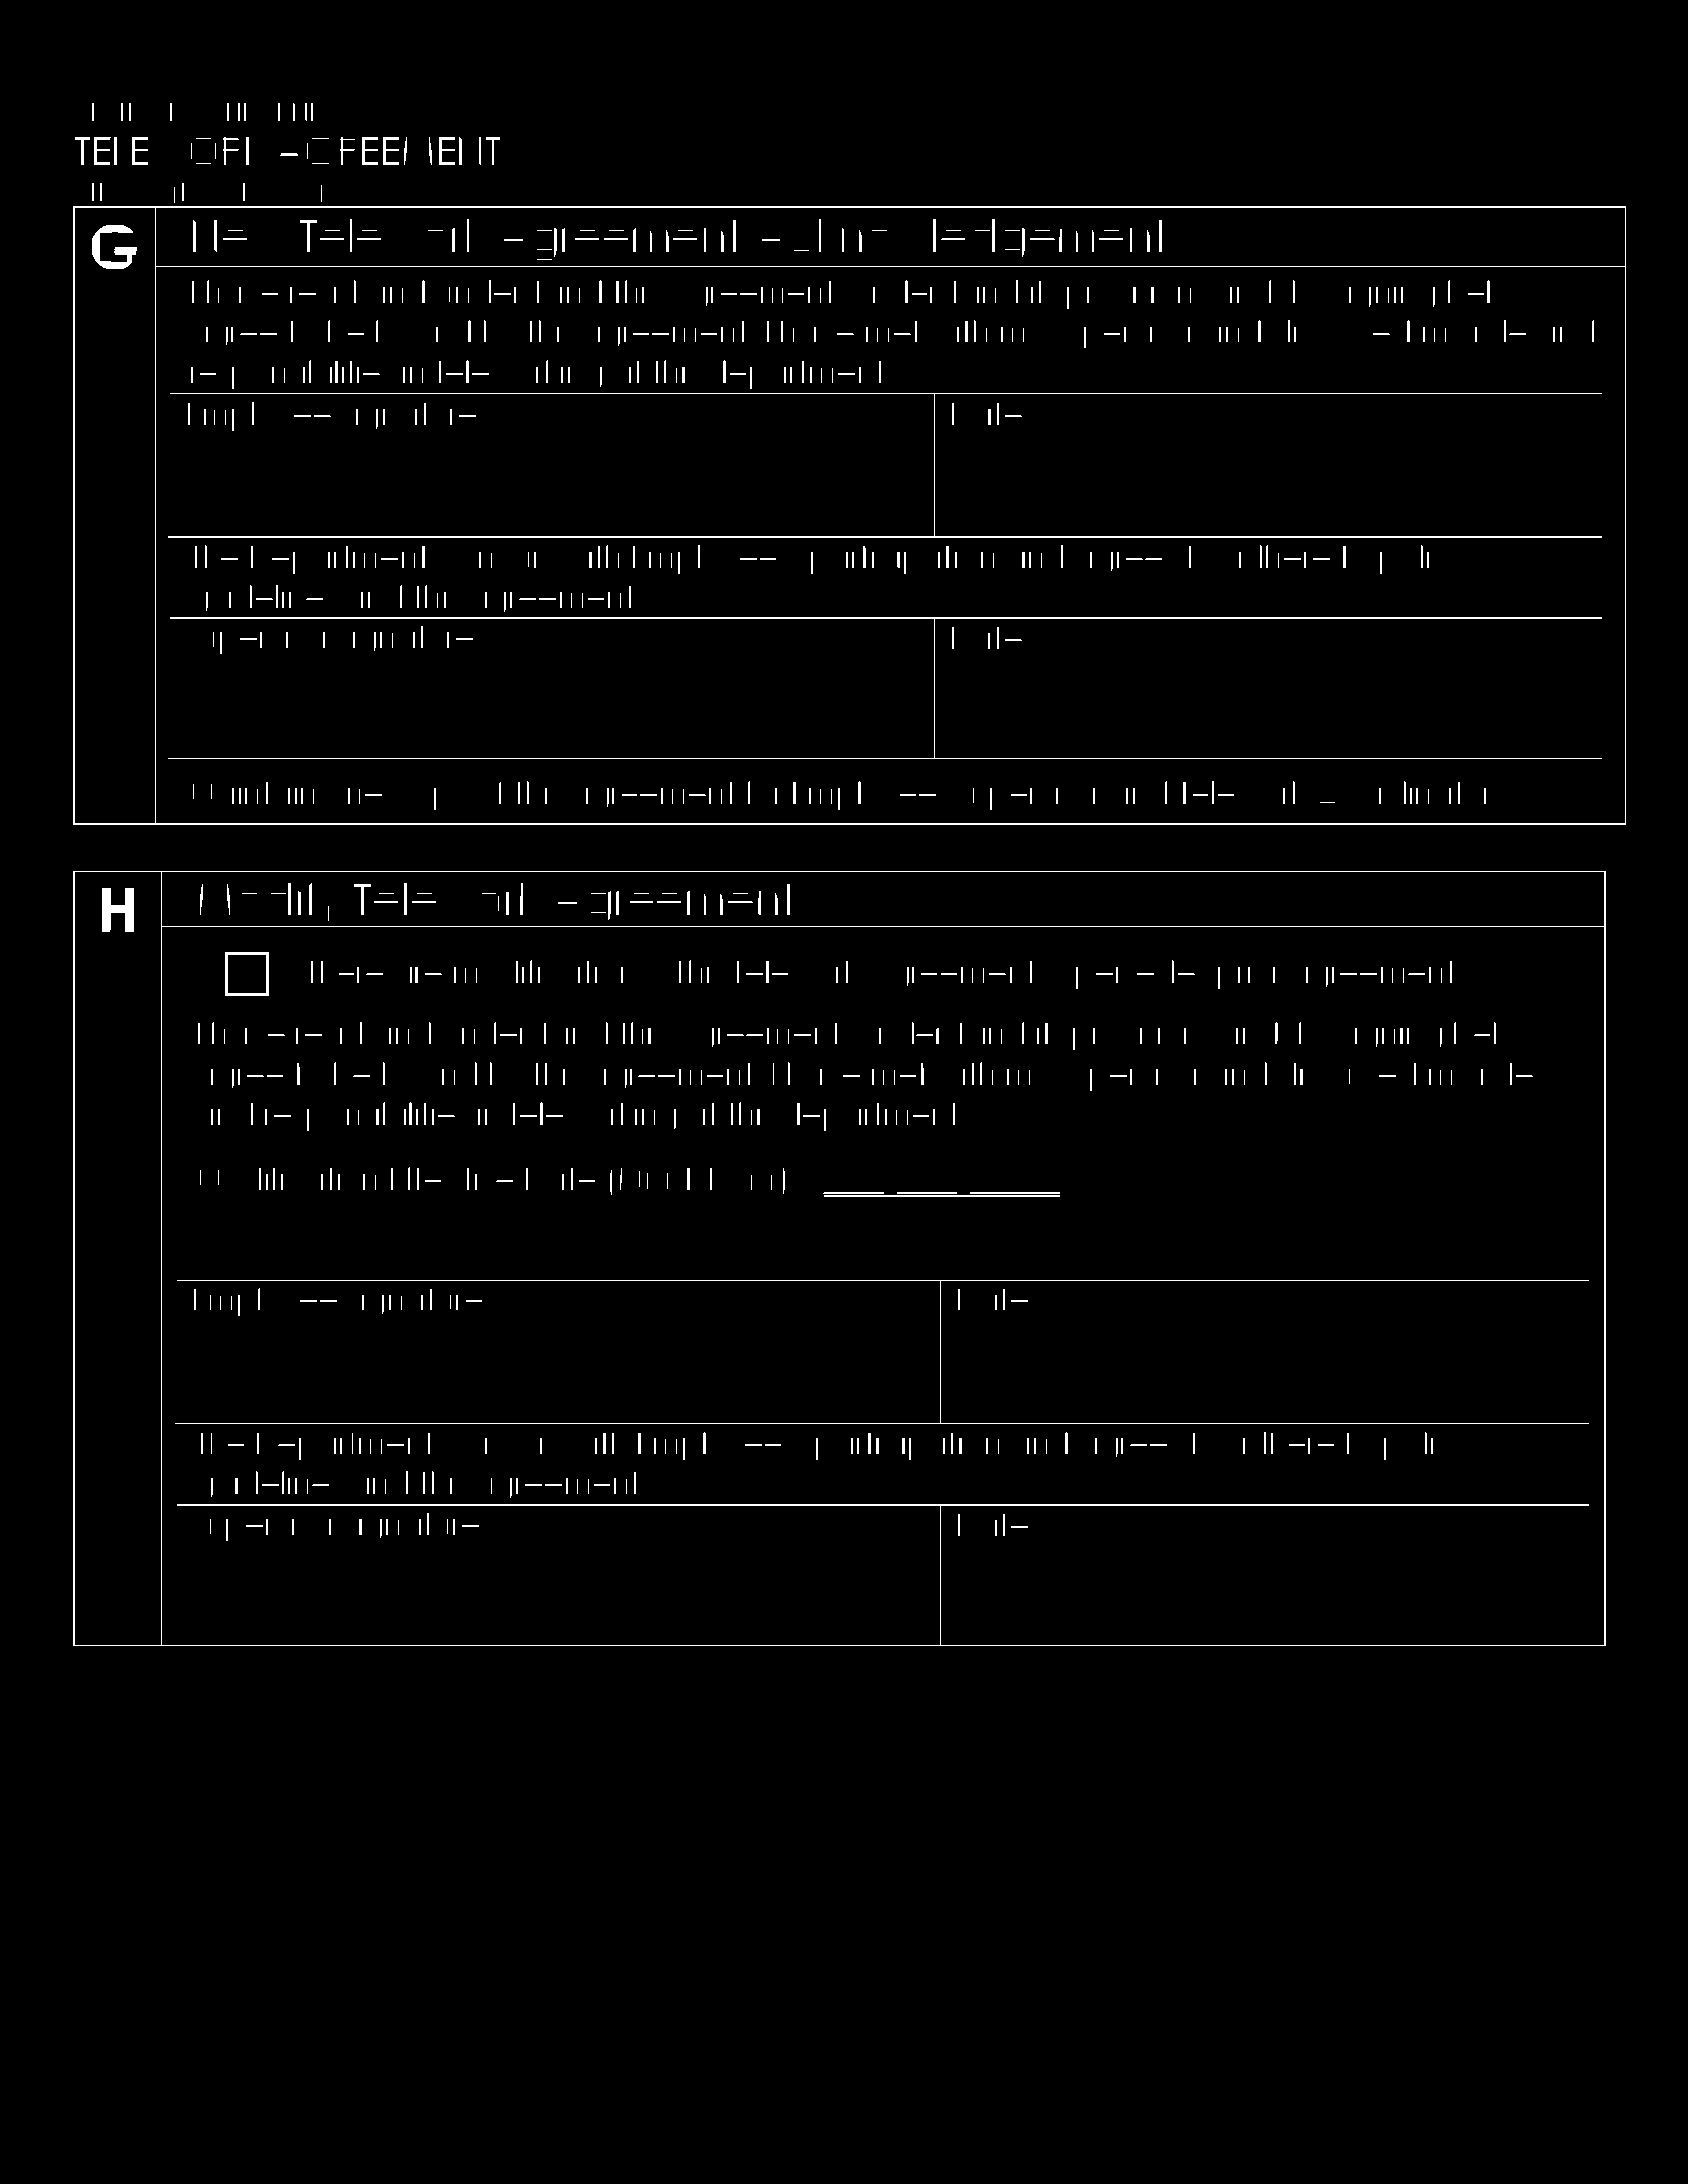

In [6]:
Image.fromarray(img_bin_final)

In [7]:
#Set parameters for Hough Line Transformation
minLineLength =  1000
minLineGap = 10

#Identify lines via Probabilistic Hough Line Transformation
lines = cv2.HoughLinesP(img_bin_final, 1, np.pi / 180, minLineLength, minLineGap)

In [8]:
#Calculates coordinates and area of boxes
_, labels, stats,_ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

In [9]:

#Initialize our vector of textless boxes
#need initial vector to achieve the correct dimensions for concatenation
blankBoxes = np.array([(0,0,0,0,0)])
signatureBoxes = np.array([(0,0,0,0,0)])

#Remove boxes with text
for x,y,w,h,area in stats[2:]:

    #Create a cropped image with just the select box
    crop_img = image_array[y:y+h, x:x+w]

    #Read text from box
    img_text = pt.image_to_string(crop_img)

    #If there's no text and the box is a reasonable size, add to array
    if (not img_text.strip()) and (area > 200) and (not w*2 < h) and (not h*2 < w):
        blankBoxes = np.concatenate((blankBoxes, [(x,y,w,h,area)]), axis=0)
    #elif ("SIGNATURE" in img_text.strip().upper()):
    #    signatureBoxes = np.concatenate((signatureBoxes, [(x,y,w,h,area)]), axis=0)


In [11]:
#Create a new array for unbounded lines
unbounded_lines = np.array([(0,0,0,0)])

#Iterate through lines to check for invalid lines
for i in range(0, len(lines)):
  invalid = False
  l = lines[i][0]

  #Iterate through list of all boxes to remove lines that are invalid
  for x, y, w, h, area in stats[2:]:
    #Remove bounding lines
    if((x-10 < l[0] < x+10) and ((y-10 < l[1] < y+10) or (y+h-10 < l[1] < y+h+10))):
      invalid = True
  #Add valid lines to new array
  if(invalid == False):
    unbounded_lines = np.concatenate((unbounded_lines, [(l[0], l[1], l[2], l[3])]), axis=0)

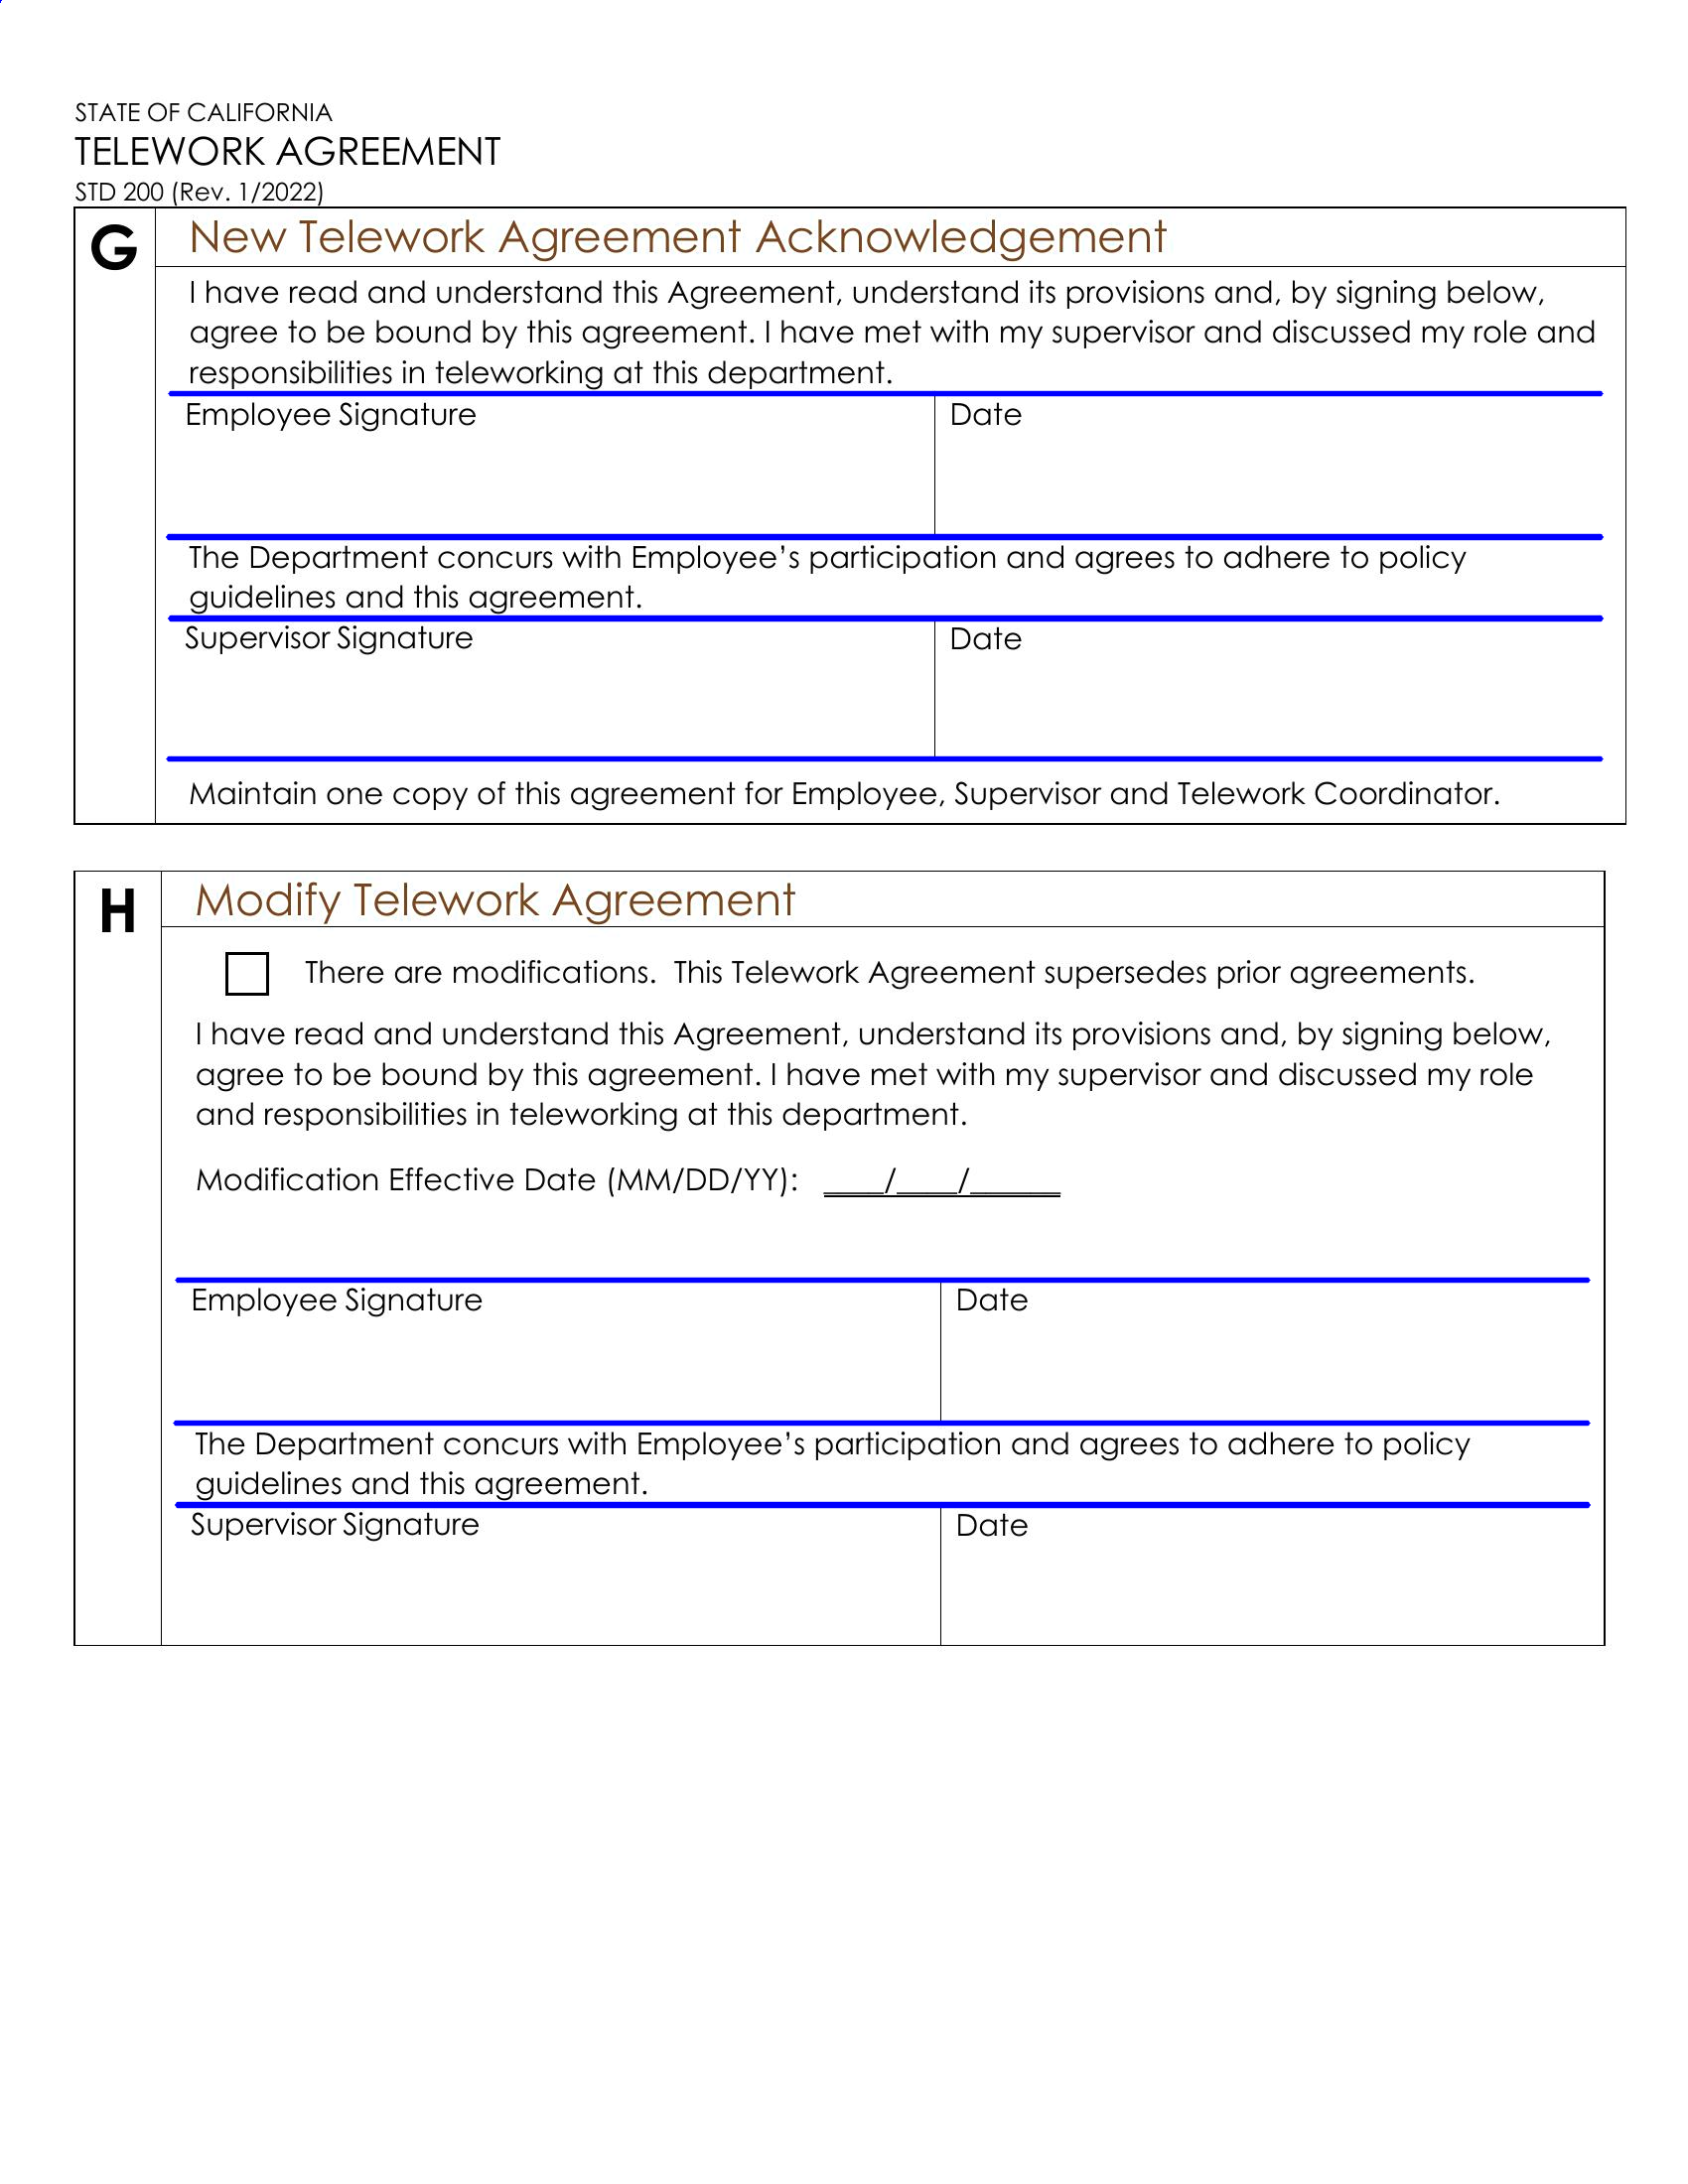

In [14]:
#Draw lines
if unbounded_lines is not None:
        for i in range(1, len(unbounded_lines)):
            cv2.line(image_array, (unbounded_lines[i][0], unbounded_lines[i][1]), (unbounded_lines[i][2], unbounded_lines[i][3]), (0,0,255), 3, cv2.LINE_AA)
Image.fromarray(image_array)

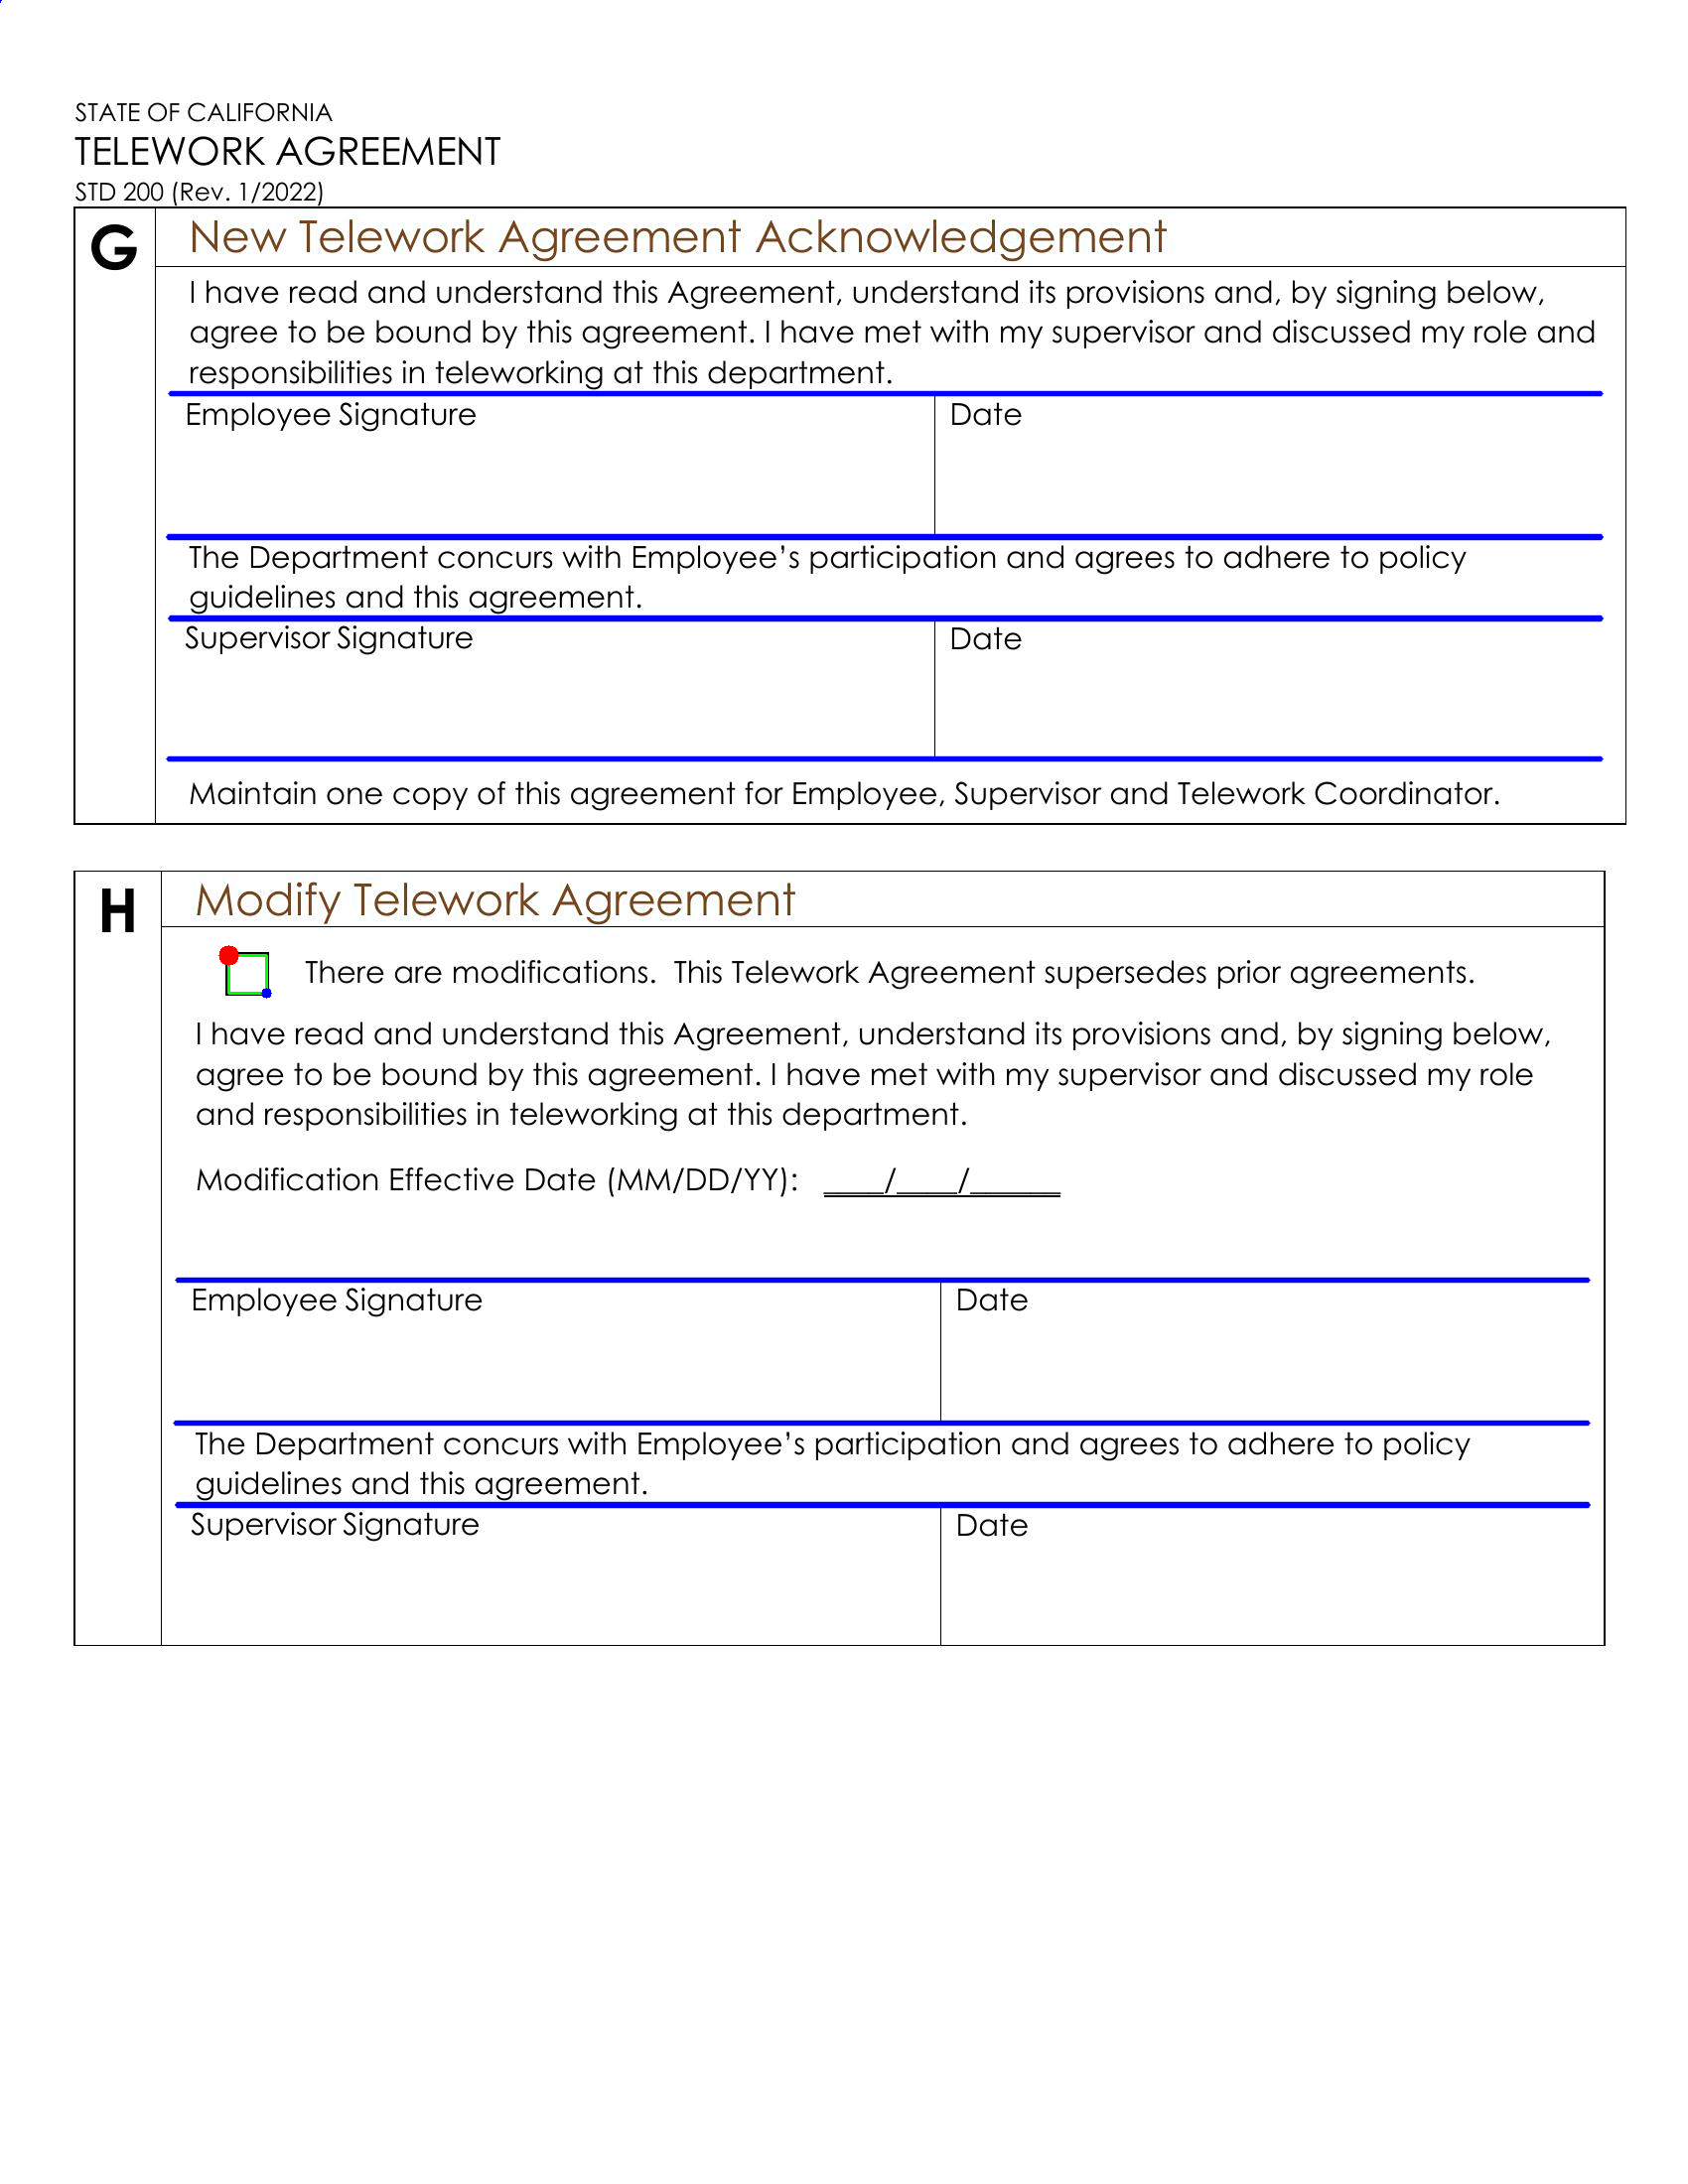

In [15]:
#Paint box boundaries and mark corners
for x,y,w,h,area in blankBoxes[1:]:
    #Apply rectangle outline
    cv2.rectangle(image_array,(x,y),(x+w,y+h),(0,255,0),2)
    #Apply upper left corner marker (Red)
    cv2.circle(image_array, (x,y), 10, (255,0,0), -1)


#Second loop to layer markers correctly
for x,y,w,h,area in blankBoxes[1:]:
    #Apply bottom right corner marker (Blue)
    cv2.circle(image_array, (x+w,y+h), 5, (0,0,255), -1)


Image.fromarray(image_array)